# Power measurement with Samna only - v0.39.9

## All experiments without network mapped on chip and no audio playing:

### Initialization and connection to the board

In [1]:
import samna
print(f'Samna version {samna.__version__}')
import numpy as np

# Open the device and connect it to the power monitor.
xylo_node = samna.device.open_device("XyloAudio3TestBoard")

power_monitor = xylo_node.get_power_monitor()
sink_pm = samna.graph.sink_from(power_monitor.get_source_node())
stopwatch = xylo_node.get_stop_watch()
io = xylo_node.get_io_module()

model = xylo_node.get_model()
source = samna.graph.source_to(model.get_sink_node())

clock_frequencies = [6.25, 12.5, 25, 50]
ts = 1e-3


power_measurements_625 = []
power_measurements_125 = []
power_measurements_25 = []
power_measurements_50 = []

Samna version 0.39.9.0


### Not explicitly calling `apply_configuration`, no chip activation (i.e., not sending `TriggerProcessing`):


In [2]:

power_consumption = []

for clock in clock_frequencies:

    config = samna.xyloAudio3.XyloAudio3TestBoardDefaultConfig()
    config.main_clock_frequency = int(clock * 1000000)

    config.saer_clock_frequency = int(config.main_clock_frequency / 8)
    config.pdm_clock_frequency = int(config.main_clock_frequency / 40)
    config.sadc_clock_frequency = int(config.main_clock_frequency / 8)

    xylo_node.reset_board_soft(config)

    # Start the stopwatch to enable time-stamped power sampling.
    stopwatch.start()
    
    # Start sampling power on all channels at a rate of 100 Hz.
    power_monitor.start_auto_power_measurement(100)
    
    # Auto power measurement streams PowerMeasurement events continuously.
    # To capture 3 seconds of data from 3 channels at 100Hz, we collect 900 events.
    events = sink_pm.get_n_events(900, timeout=4000)
    
    # Stop the automatic power measurement process.
    power_monitor.stop_auto_power_measurement()
    
    # Calculate the average power consumption for each channel over 3 seconds.
    counts = [0, 0, 0]
    sums = [0, 0, 0]
    for e in events:
        assert isinstance(e, samna.unifirm.modules.events.PowerMeasurement)
        sums[e.channel] += e.value
        counts[e.channel] += 1
    
    # Compute the averages and convert to milliwatts (W -> mW).
    avgs = [sum/count * 1000 for sum, count in zip(sums, counts)]
    power_consumption+= [avgs]

for clock, power in zip(clock_frequencies, power_consumption):
    print(f'Clock:\t{clock} MHz\nio:\t{power[0] * 1000:.1f} uW\tAFE core:\t{power[1] * 1000:.1f} uW\tDFE+SNN core:\t{power[2] * 1000:.1f} uW')

    match clock:
        case 6.25:
            power_measurements_625.append(power)
        case 12.5:
            power_measurements_125.append(power)
        case 25:
            power_measurements_25.append(power)
        case 50:
            power_measurements_50.append(power)
        

Clock:	6.25 MHz
io:	36.0 uW	AFE core:	13.8 uW	DFE+SNN core:	296.4 uW
Clock:	12.5 MHz
io:	66.9 uW	AFE core:	12.9 uW	DFE+SNN core:	449.5 uW
Clock:	25 MHz
io:	128.4 uW	AFE core:	12.7 uW	DFE+SNN core:	756.6 uW
Clock:	50 MHz
io:	235.6 uW	AFE core:	13.5 uW	DFE+SNN core:	1375.8 uW


### Explicitly calling `apply_configuration` but with the default configuration, no chip activation (i.e., not sending `TriggerProcessing`):


In [3]:
power_consumption = []

for clock in clock_frequencies:
    
    config = samna.xyloAudio3.XyloAudio3TestBoardDefaultConfig()
    config.main_clock_frequency = int(clock * 1000000)

    config.saer_clock_frequency = int(config.main_clock_frequency / 8)
    config.pdm_clock_frequency = int(config.main_clock_frequency / 40)
    config.sadc_clock_frequency = int(config.main_clock_frequency / 8)

    xylo_node.reset_board_soft(config)
    
    config = samna.xyloAudio3.configuration.XyloConfiguration()
    xylo_node.get_model().apply_configuration(config)
    xylo_node.get_model().close_ram_access()

    # Start the stopwatch to enable time-stamped power sampling.
    stopwatch.start()
    
    # Start sampling power on all channels at a rate of 100 Hz.
    power_monitor.start_auto_power_measurement(100)
    
    # Auto power measurement streams PowerMeasurement events continuously.
    # To capture 3 seconds of data from 3 channels at 100Hz, we collect 900 events.
    events = sink_pm.get_n_events(900, timeout=4000)
    
    # Stop the automatic power measurement process.
    power_monitor.stop_auto_power_measurement()
    
    # Calculate the average power consumption for each channel over 3 seconds.
    counts = [0, 0, 0]
    sums = [0, 0, 0]
    for e in events:
        assert isinstance(e, samna.unifirm.modules.events.PowerMeasurement)
        sums[e.channel] += e.value
        counts[e.channel] += 1
    
    # Compute the averages and convert to milliwatts (W -> mW).
    avgs = [sum/count * 1000 for sum, count in zip(sums, counts)]
    power_consumption+= [avgs]

for clock, power in zip(clock_frequencies, power_consumption):
    print(f'Clock:\t{clock} MHz\nio:\t{power[0] * 1000:.1f} uW\tAFE core:\t{power[1] * 1000:.1f} uW\tDFE+SNN core:\t{power[2] * 1000:.1f} uW')

    match clock:
        case 6.25:
            power_measurements_625.append(power)
        case 12.5:
            power_measurements_125.append(power)
        case 25:
            power_measurements_25.append(power)
        case 50:
            power_measurements_50.append(power)


Clock:	6.25 MHz
io:	38.6 uW	AFE core:	13.6 uW	DFE+SNN core:	302.0 uW
Clock:	12.5 MHz
io:	72.0 uW	AFE core:	12.8 uW	DFE+SNN core:	455.5 uW
Clock:	25 MHz
io:	136.9 uW	AFE core:	12.9 uW	DFE+SNN core:	773.1 uW
Clock:	50 MHz
io:	251.4 uW	AFE core:	13.6 uW	DFE+SNN core:	1407.2 uW


### Explicitly calling `apply_configuration` but with the default configuration, with chip activation (i.e., sending one `TriggerProcessing`):


In [4]:
power_consumption = []

for clock in clock_frequencies:
    
    config = samna.xyloAudio3.XyloAudio3TestBoardDefaultConfig()
    config.main_clock_frequency = int(clock * 1000000)

    config.saer_clock_frequency = int(config.main_clock_frequency / 8)
    config.pdm_clock_frequency = int(config.main_clock_frequency / 40)
    config.sadc_clock_frequency = int(config.main_clock_frequency / 8)

    xylo_node.reset_board_soft(config)
    
    config = samna.xyloAudio3.configuration.XyloConfiguration()
    xylo_node.get_model().apply_configuration(config)
    xylo_node.get_model().close_ram_access()

    # ## IMPORTANT register to write to save power on digital core
    # wwv_ev = samna.xyloAudio3.event.WriteRegisterValue()
    # wwv_ev.address = 0x0001
    # wwv_ev.data = 0x1420000
    # source.write([wwv_ev])
    
    # Activate the chip processing
    source.write([samna.xyloAudio3.event.TriggerProcessing()])

    # Start the stopwatch to enable time-stamped power sampling.
    stopwatch.start()
    
    # Start sampling power on all channels at a rate of 100 Hz.
    power_monitor.start_auto_power_measurement(100)
    
    # Auto power measurement streams PowerMeasurement events continuously.
    # To capture 3 seconds of data from 3 channels at 100Hz, we collect 900 events.
    events = sink_pm.get_n_events(900, timeout=4000)
    
    # Stop the automatic power measurement process.
    power_monitor.stop_auto_power_measurement()
    
    # Calculate the average power consumption for each channel over 3 seconds.
    counts = [0, 0, 0]
    sums = [0, 0, 0]
    for e in events:
        assert isinstance(e, samna.unifirm.modules.events.PowerMeasurement)
        sums[e.channel] += e.value
        counts[e.channel] += 1
    
    # Compute the averages and convert to milliwatts (W -> mW).
    avgs = [sum/count * 1000 for sum, count in zip(sums, counts)]
    power_consumption+= [avgs]

for clock, power in zip(clock_frequencies, power_consumption):
    print(f'Clock:\t{clock} MHz\nio:\t{np.ceil(power[0] * 1000):.0f} uW\tAFE core:\t{np.ceil(power[1] * 1000):.0f} uW\tDFE+SNN core:\t{np.ceil(power[2] * 1000):.0f} uW')
    
    match clock:
        case 6.25:
            power_measurements_625.append(power)
        case 12.5:
            power_measurements_125.append(power)
        case 25:
            power_measurements_25.append(power)
        case 50:
            power_measurements_50.append(power)


Clock:	6.25 MHz
io:	39 uW	AFE core:	14 uW	DFE+SNN core:	302 uW
Clock:	12.5 MHz
io:	72 uW	AFE core:	14 uW	DFE+SNN core:	457 uW
Clock:	25 MHz
io:	138 uW	AFE core:	14 uW	DFE+SNN core:	775 uW
Clock:	50 MHz
io:	253 uW	AFE core:	13 uW	DFE+SNN core:	1404 uW


### Explicitly calling `apply_configuration` with the same configuration applied in `XyloMonitor` for `RealTime` mode, no chip activation (i.e., not sending `TriggerProcessing`):


In [5]:
power_consumption = []
for clock in clock_frequencies:

    config = samna.xyloAudio3.XyloAudio3TestBoardDefaultConfig()
    config.main_clock_frequency = int(clock * 1000000)

    config.saer_clock_frequency = int(config.main_clock_frequency / 8)
    config.pdm_clock_frequency = int(config.main_clock_frequency / 40)
    config.sadc_clock_frequency = int(config.main_clock_frequency / 8)

    xylo_node.reset_board_soft(config)


    main_clk_freq = clock * 1e6  # in Hz
    tr_wrap = int(ts * main_clk_freq)
    
    config = samna.xyloAudio3.configuration.XyloConfiguration()
    config.operation_mode = samna.xyloAudio3.OperationMode.RealTime
    config.digital_frontend.filter_bank.dn_enable = False
    config.time_resolution_wrap = tr_wrap
    config.debug.always_update_omp_stat = True
    config.digital_frontend.filter_bank.use_global_iaf_threshold = False
    config.input_source = samna.xyloAudio3.InputSource.DigitalMicrophone
    # - the ideal sdm clock ratio depends on the main clock rate
    # -- int(clock / 1.56 / 2 - 1)
    config.debug.sdm_clock_ratio = 24
    config.digital_frontend.pdm_preprocessing.clock_direction = 1
    config.digital_frontend.pdm_preprocessing.clock_edge = 0
    
    # - Disable internal state monitoring
    config.debug.monitor_neuron_v_mem = []
    config.debug.monitor_neuron_spike = []
    config.debug.monitor_neuron_i_syn = []

    xylo_node.get_model().apply_configuration(config)
    xylo_node.get_model().close_ram_access()

    # wwv_ev = samna.xyloAudio3.event.WriteRegisterValue()
    # wwv_ev.address = 0x0006
    # wwv_ev.data = 0x1
    # source.write([wwv_ev])

    # ## IMPORTANT register to write to save power on digital core
    # wwv_ev = samna.xyloAudio3.event.WriteRegisterValue()
    # wwv_ev.address = 0x0001
    # wwv_ev.data = 0x1420000
    # source.write([wwv_ev])

    # print(hex(read_register(clk_ctrl)))
    # print(hex(read_register(clk_div)))
    # print(hex(read_register(dbg_ctrl1)))
    # print(hex(read_register(ctrl1)))

    # Start the stopwatch to enable time-stamped power sampling.
    stopwatch.start()
    
    # Start sampling power on all channels at a rate of 100 Hz.
    power_monitor.start_auto_power_measurement(100)
    
    # Auto power measurement streams PowerMeasurement events continuously.
    # To capture 3 seconds of data from 3 channels at 100Hz, we collect 900 events.
    events = sink_pm.get_n_events(900, timeout=4000)
    
    # Stop the automatic power measurement process.
    power_monitor.stop_auto_power_measurement()
    
    # Calculate the average power consumption for each channel over 3 seconds.
    counts = [0, 0, 0]
    sums = [0, 0, 0]
    for e in events:
        assert isinstance(e, samna.unifirm.modules.events.PowerMeasurement)
        sums[e.channel] += e.value
        counts[e.channel] += 1
    
    # Compute the averages and convert to milliwatts (W -> mW).
    avgs = [sum/count * 1000 for sum, count in zip(sums, counts)]
    power_consumption+= [avgs]

for clock, power in zip(clock_frequencies, power_consumption):
    print(f'Clock:\t{clock} MHz\nio:\t{np.ceil(power[0] * 1000):.0f} uW\tAFE core:\t{np.ceil(power[1] * 1000):.0f} uW\tDFE+SNN core:\t{np.ceil(power[2] * 1000):.0f} uW')
    
    match clock:
        case 6.25:
            power_measurements_625.append(power)
        case 12.5:
            power_measurements_125.append(power)
        case 25:
            power_measurements_25.append(power)
        case 50:
            power_measurements_50.append(power)


Clock:	6.25 MHz
io:	69 uW	AFE core:	14 uW	DFE+SNN core:	302 uW
Clock:	12.5 MHz
io:	132 uW	AFE core:	13 uW	DFE+SNN core:	455 uW
Clock:	25 MHz
io:	257 uW	AFE core:	14 uW	DFE+SNN core:	771 uW
Clock:	50 MHz
io:	492 uW	AFE core:	13 uW	DFE+SNN core:	1403 uW


### Explicitly calling `apply_configuration` with the same configuration applied in `XyloMonitor` for `RealTime` mode, with chip activation (i.e., sending one `TriggerProcessing`):


In [6]:
power_consumption = []
for clock in clock_frequencies:

    config = samna.xyloAudio3.XyloAudio3TestBoardDefaultConfig()
    config.main_clock_frequency = int(clock * 1000000)

    config.saer_clock_frequency = int(config.main_clock_frequency / 8)
    config.pdm_clock_frequency = int(config.main_clock_frequency / 40)
    config.sadc_clock_frequency = int(config.main_clock_frequency / 8)

    xylo_node.reset_board_soft(config)

    main_clk_freq = clock * 1e6  # in Hz
    tr_wrap = int(ts * main_clk_freq)
    
    config = samna.xyloAudio3.configuration.XyloConfiguration()
    config.operation_mode = samna.xyloAudio3.OperationMode.RealTime
    config.digital_frontend.filter_bank.dn_enable = False
    config.time_resolution_wrap = tr_wrap
    config.debug.always_update_omp_stat = True
    config.digital_frontend.filter_bank.use_global_iaf_threshold = False
    config.input_source = samna.xyloAudio3.InputSource.DigitalMicrophone
    # - the ideal sdm clock ratio depends on the main clock rate
    # -- int(clock / 1.56 / 2 - 1)
    config.debug.sdm_clock_ratio = 24
    config.digital_frontend.pdm_preprocessing.clock_direction = 1
    config.digital_frontend.pdm_preprocessing.clock_edge = 0
    
    # - Disable internal state monitoring
    config.debug.monitor_neuron_v_mem = []
    config.debug.monitor_neuron_spike = []
    config.debug.monitor_neuron_i_syn = []

    xylo_node.get_model().apply_configuration(config)
    xylo_node.get_model().close_ram_access()

    # ## IMPORTANT register to write to save power on digital core
    # wwv_ev = samna.xyloAudio3.event.WriteRegisterValue()
    # wwv_ev.address = 0x0001
    # wwv_ev.data = 0x1420000
    # source.write([wwv_ev])
    
    # Activate the chip processing
    source.write([samna.xyloAudio3.event.TriggerProcessing()])


    # Start the stopwatch to enable time-stamped power sampling.
    stopwatch.start()
    
    # Start sampling power on all channels at a rate of 100 Hz.
    power_monitor.start_auto_power_measurement(100)
    
    # Auto power measurement streams PowerMeasurement events continuously.
    # To capture 3 seconds of data from 3 channels at 100Hz, we collect 900 events.
    events = sink_pm.get_n_events(900, timeout=4000)
    
    # Stop the automatic power measurement process.
    power_monitor.stop_auto_power_measurement()
    
    # Calculate the average power consumption for each channel over 3 seconds.
    counts = [0, 0, 0]
    sums = [0, 0, 0]
    for e in events:
        assert isinstance(e, samna.unifirm.modules.events.PowerMeasurement)
        sums[e.channel] += e.value
        counts[e.channel] += 1
    
    # Compute the averages and convert to milliwatts (W -> mW).
    avgs = [sum/count * 1000 for sum, count in zip(sums, counts)]
    power_consumption+= [avgs]

for clock, power in zip(clock_frequencies, power_consumption):
    print(f'Clock:\t{clock} MHz\nio:\t{np.ceil(power[0] * 1000):.0f} uW\tAFE core:\t{np.ceil(power[1] * 1000):.0f} uW\tDFE+SNN core:\t{np.ceil(power[2] * 1000):.0f} uW')
    
    match clock:
        case 6.25:
            power_measurements_625.append(power)
        case 12.5:
            power_measurements_125.append(power)
        case 25:
            power_measurements_25.append(power)
        case 50:
            power_measurements_50.append(power)


Clock:	6.25 MHz
io:	1477 uW	AFE core:	17 uW	DFE+SNN core:	306 uW
Clock:	12.5 MHz
io:	1490 uW	AFE core:	17 uW	DFE+SNN core:	481 uW
Clock:	25 MHz
io:	1664 uW	AFE core:	15 uW	DFE+SNN core:	797 uW
Clock:	50 MHz
io:	1898 uW	AFE core:	15 uW	DFE+SNN core:	1448 uW


### Plot all power consumption together

In [7]:
power_measurements_625


[[0.035954999047381385, 0.013772380473350646, 0.2964231943769846],
 [0.038648114362634566, 0.013623129112119159, 0.3019588388754831],
 [0.03820402261832593, 0.013431315928708424, 0.3012419603085921],
 [0.06887956162245246, 0.013171550246984983, 0.3015538913799295],
 [1.4762312811702336, 0.01621305449868752, 0.3059896810736973]]

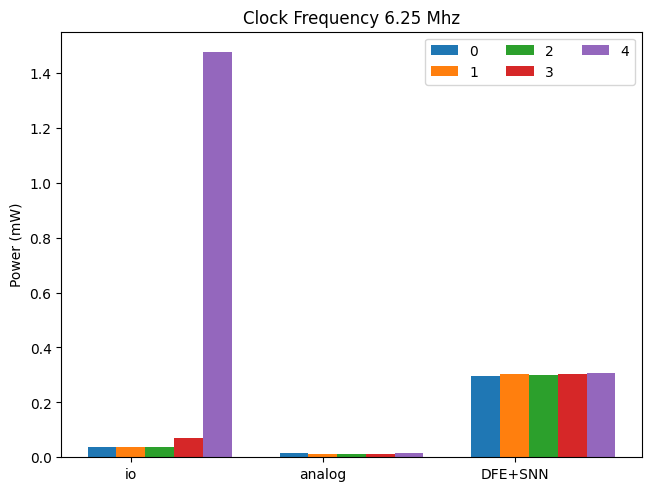

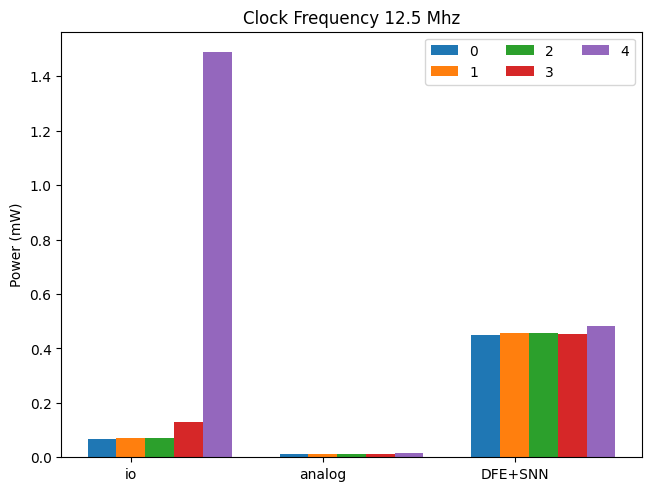

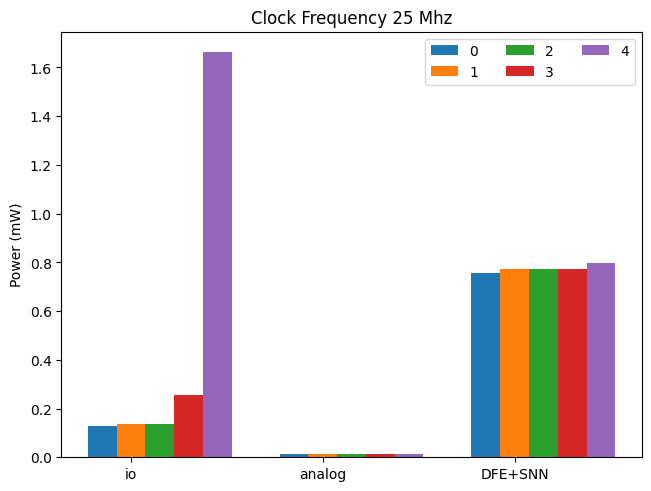

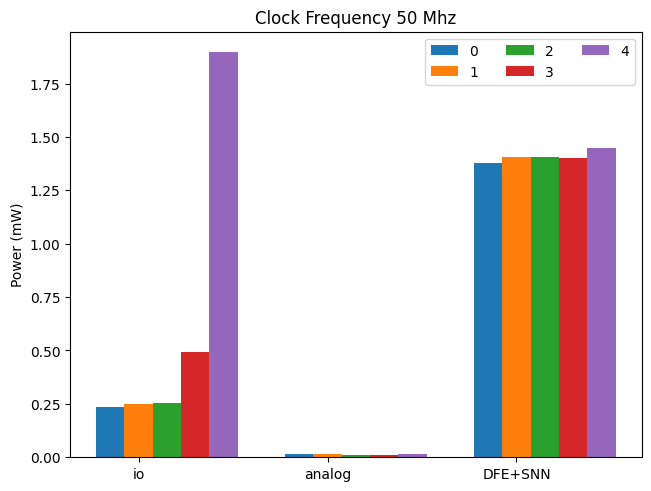

In [8]:
import numpy as np
import matplotlib.pyplot as plt


frequency_measurement = [power_measurements_625, power_measurements_125, power_measurements_25, power_measurements_50]

for frequency, clock in zip(frequency_measurement, clock_frequencies):
    power_labels = ["io", "analog", "DFE+SNN"]
    
    number_experiment = []
    for i in range(len(frequency)):
        number_experiment.append(i)
        
    x = np.arange(len(power_labels))  # the label locations
    width = 0.15  # the width of the bars
    multiplier = 0
    
    fig, ax = plt.subplots(layout='constrained')

    for measurement, label in zip(frequency, number_experiment):
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=label)
        multiplier += 1
    
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Power (mW)')
    title = "Clock Frequency " + str(clock) + " Mhz"
    ax.set_title(title)
    ax.set_xticks(x + width, power_labels)
    ax.legend(loc='best', ncols=3)
    
    plt.show()

In [9]:
def read_register(addr):
    source.write([samna.xyloAudio3.event.ReadRegisterValue(address = addr)])
    events = sink.get_n_events(1, 3000)
    assert(len(events) == 1)
    return events[0].data

ctrl1 = 0x0001
ctrl2 = 0x0002
ctrl3 = 0x0003
tr_wrap = 0x0004
hm_tr_wrap = 0x0005
clk_ctrl = 0x0006
clk_div = 0x0007
pwr_ctrl1 = 0x0008
pwr_ctrl2 = 0x0009
pwr_ctrl3 = 0x000A
pwr_ctrl4 = 0x000B
pad_ctrl = 0x000C
ie1 = 0x000E
ie2 = 0x000F
out_ctrl = 0x0011
monsel = 0x0166
mon_grp_sel = 0x0167
dbg_ctrl1 = 0x0168
dbg_stat1 = 0x0171
dfe_ctrl = 0x001B
ivgen = 0x0015
ivgen2 = 0x0016
ivgen3 = 0x0017
ivgen4 = 0x0018
ivgen5 = 0x0019
ivgen6 = 0x001A
adctest = 0x016E

# create access to xylo input/output
source = samna.graph.source_to(model.get_sink_node())
sink   = samna.graph.sink_from(model.get_source_node())